In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from tqdm import tqdm
import pandas as pd
import time
import math
from scipy import signal
from scipy.spatial import distance

In [70]:
image_dir = '1327317/training_set/training_set'
# Read images and store filenames
image_data = []
filenames = []
target_size = (800, 540)  # Consistent size for all images

for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        image_path = os.path.join(image_dir, filename)
        # Read image using OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Resize image to target size
        image = cv2.resize(image, target_size)
        # Append data to lists
        image_data.append(image)
        filenames.append(filename)

# Convert lists to NumPy arrays
image_data = np.array(image_data)  # No need for dtype=object since all images are the same size now

# Verify the shapes of the image_data
print("Image Data Shape:", image_data.shape)

Image Data Shape: (1998, 540, 800)


In [73]:
csv_data = pd.read_csv('1327317\\training_set_pixel_size_and_HC.csv')

In [74]:
#create labels and image sets
X = image_data[::2]
Y = image_data[1::2]


In [75]:
#resize the images and labels
IMG_CHANNELS = 1
IMG_WIDTH = 128
IMG_HEIGHT = 128
X_resize = np.zeros((999,IMG_HEIGHT,IMG_WIDTH))
Y_resize = np.zeros((999,IMG_HEIGHT,IMG_WIDTH))

for i in range(999):
    X_resize[i] = cv2.resize(X[i],(128,128))
    Y_resize[i] = cv2.resize(Y[i],(128,128))

In [76]:
csv_data

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81
...,...,...,...
994,801_HC.png,0.296851,329.26
995,802_HC.png,0.212267,330.90
996,803_HC.png,0.202743,331.70
997,804_HC.png,0.281090,316.48


In [88]:
#split dataset into training and test sets 4:1
X_train, X_test, Y_train, Y_test,head_circumference_train,head_circumference_test,pixel_sizes_train,pixel_sizes_test = train_test_split(X_resize,Y_resize,csv_data['head circumference (mm)'],csv_data['pixel size(mm)'],test_size=0.2, random_state=4,shuffle=True)

In [90]:
import tensorflow as tf
import numpy as np

# Define constants
IMG_CHANNELS = 1
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Define the convolutional block
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
    return x

# Define the upsampling block
def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv

# Inputs
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

# Normalization
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs)

# Contraction path
c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

# Expansive path (Segmentation)
c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)

# Segmentation Output
seg_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name='seg_output')(c9)

# Regression Head for HC Prediction
# Use the bottleneck features (c5) for regression
x = tf.keras.layers.GlobalAveragePooling2D()(c5)  # Reduce spatial dimensions
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
hc_output = tf.keras.layers.Dense(1, activation='linear', name='hc_output')(x)  # Linear activation for regression

# Define the model with two outputs
model = tf.keras.Model(inputs=[inputs], outputs=[seg_output, hc_output])

# Summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 128, 128,  │        160 │ lambda_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128, 128,  │          0 │ conv2d_37[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_18[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ conv2d_38[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 64, 64,    │          0 │ conv2d_39[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_19[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 32, 32,    │          0 │ conv2d_41[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_20[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ conv2d_42[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 16, 16,    │          0 │ conv2d_43[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_21[0][0]

 Total params: 2,203,986 (8.41 MB)

 Trainable params: 2,203,986 (8.41 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'seg_output': dice_loss,
        'hc_output': tf.keras.losses.MeanSquaredError()
    },
    loss_weights={
        'seg_output': 1.0,
        'hc_output': 0.1
    },
    metrics={
        'seg_output': ['accuracy'],
        'hc_output': ['mae']
    }
)

In [ ]:
results = model.fit(
    X_train,
    {'seg_output': Y_train, 'hc_output': head_circumference_train},
    validation_split=0.1,
    batch_size=16,
    epochs=25,
    verbose=1
)

In [93]:
seg_preds, hc_preds = model.predict(X_test, batch_size=16)

seg_preds_binary = (seg_preds > 0.5).astype(np.uint8)  
hc_preds = hc_preds.flatten()  

print("Segmentation Predictions Shape:", seg_preds_binary.shape)
print("HC Predictions Shape:", hc_preds.shape)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Segmentation Predictions Shape: (200, 128, 128, 1)
HC Predictions Shape: (200,)


In [94]:
import numpy as np

# Flatten the masks for pixel-wise metrics
y_test_flat = Y_test.flatten()
seg_preds_flat = seg_preds_binary.flatten()

# Pixel-wise Accuracy
accuracy = np.mean(y_test_flat == seg_preds_flat)
print(f"Pixel-wise Accuracy: {accuracy:.4f}")

# Dice Score
def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# IoU (Intersection over Union)
def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Compute Dice and IoU for each sample and take the average
dice_scores = []
iou_scores = []

for i in range(len(Y_test)):
    dice = dice_score(Y_test[i], seg_preds_binary[i])
    iou = iou_score(Y_test[i], seg_preds_binary[i])
    dice_scores.append(dice)
    iou_scores.append(iou)

mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")

Pixel-wise Accuracy: 0.7818
Mean Dice Score: 63.6767
Mean IoU Score: -1.0334


In [118]:
type(pixel_sizes_test)

pandas.core.series.Series

In [125]:
import cv2
import numpy as np

# Convert pixel_sizes_test to a NumPy array
#pixel_sizes_test = pixel_sizes_test.to_numpy()  # Shape: (200,)

# Function to compute HC from a binary mask
def compute_circumference(mask, pixel_size):
    mask = mask.squeeze().astype(np.uint8)  # Shape: (128, 128)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        perimeter_pixels = cv2.arcLength(contours[0], closed=True)  # Perimeter in pixels
        return perimeter_pixels * pixel_size  # Convert to mm
    return 0

hc_from_seg = [compute_circumference(seg_preds_binary[i], pixel_sizes_test[i]) for i in range(len(seg_preds_binary))]

hc_from_seg = np.array(hc_from_seg)
hc_true = np.array(head_circumference_test)

mae_hc_seg = np.mean(np.abs(hc_from_seg - hc_true))
mre_hc_seg = np.mean([abs(pred - true) / true * 100 if true > 0 else 0 for pred, true in zip(hc_from_seg, hc_true)])

print(f"MAE (HC from Segmentation in mm): {mae_hc_seg:.2f} mm")
print(f"MRE (HC from Segmentation in mm): {mre_hc_seg:.2f}%")

MAE (HC from Segmentation in mm): 145.80 mm
MRE (HC from Segmentation in mm): 85.27%


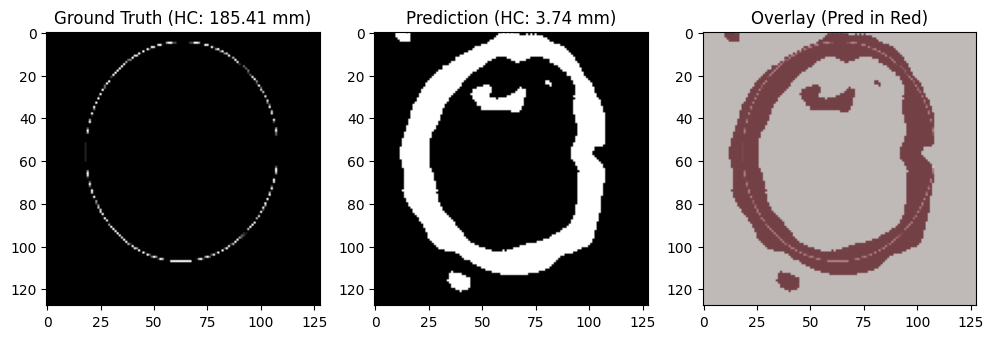

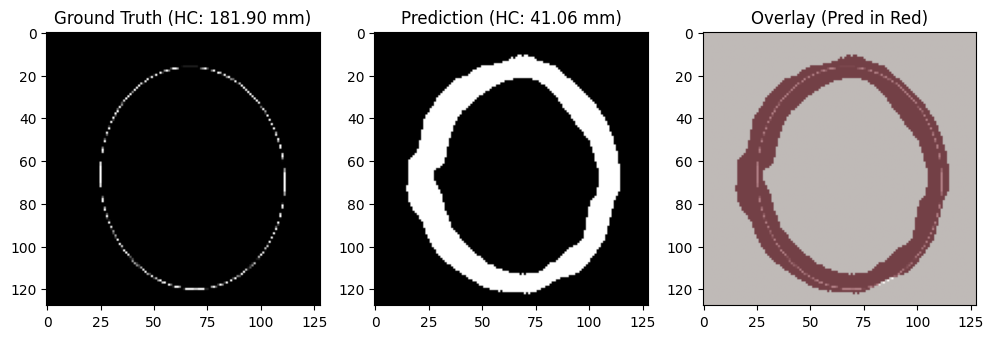

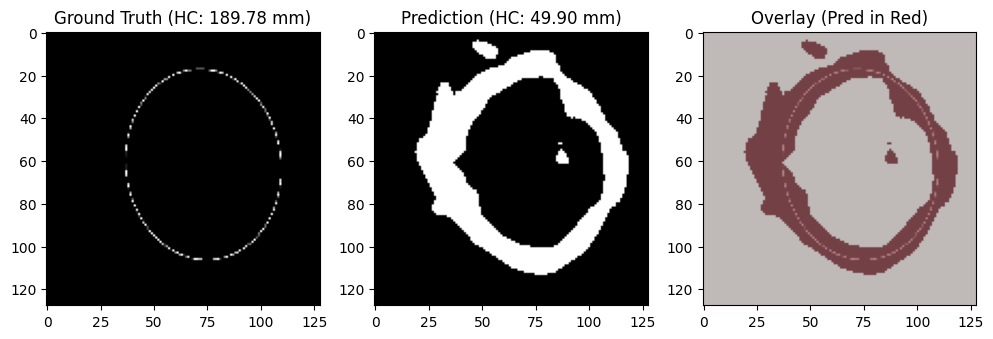

In [ ]:
# Visualize results
head_circumference_test = head_circumference_test.to_numpy()
n_samples = 3
for i in range(n_samples):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title(f"Ground Truth (HC: {head_circumference_test[i]:.2f} mm)")
    plt.imshow(Y_test[i].squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title(f"Prediction (HC: {hc_from_seg[i]:.2f} mm)")
    plt.imshow(seg_preds_binary[i].squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Overlay (Pred in Red)")
    plt.imshow(Y_test[i].squeeze(), cmap='gray', alpha=0.5)
    plt.imshow(seg_preds_binary[i].squeeze(), cmap='Reds', alpha=0.5)
    plt.show()

In [ ]:
# Predictions
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
preds_test_binary = preds_test_t.squeeze()

Text(0.5, 1.0, 'Predicted Label')

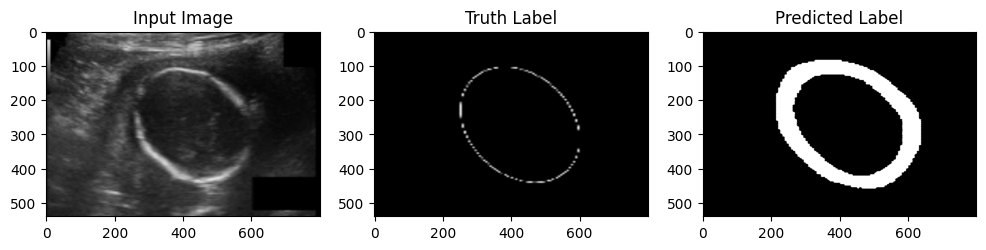

In [11]:
# Select a random index from test set
ix = random.randint(0, len(preds_test_t))

fig ,ax = plt.subplots(1,3,figsize=(12,6))
# Display the input image
ax[0].imshow(cv2.resize(X_test[ix],(800,540)),cmap='gray')
ax[0].set_title("Input Image")

# Display the ground truth label
ax[1].imshow(cv2.resize(Y_test[ix],(800,540)),cmap='gray')
ax[1].set_title("Truth Label")

# Display the predicted lebel
ax[2].imshow(cv2.resize(np.squeeze(preds_test_t[ix]),(800,540)),cmap='gray')
ax[2].set_title("Predicted Label")

In [ ]:
print("pred_test shape:", preds_test_binary.shape)
print("y_test shape:", Y_test.shape)
print("pred_test range:", preds_test_binary.min(), preds_test.max())
print("y_test range:", Y_test.min(), Y_test.max())
y_test_binary = (Y_test > 0).astype(np.uint8)

In [63]:
pred_flat = preds_test_binary.flatten()
y_flat = y_test_binary.flatten()

# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

dice = dice_coefficient(y_flat, pred_flat)
print(f"Dice Coefficient: {dice:.4f}")

# IoU (Jaccard Score)
from sklearn.metrics import jaccard_score
iou = jaccard_score(y_flat, pred_flat, average='binary')
print(f"IoU (Jaccard): {iou:.4f}")

# Pixel-wise Accuracy
accuracy = np.mean(pred_flat == y_flat)
print(f"Pixel Accuracy: {accuracy:.4f}")

Dice Coefficient: 0.1468
IoU (Jaccard): 0.0792
Pixel Accuracy: 0.8725


MAE (HC in mm): 253.89 mm
MRE (HC in mm): 2526.51%


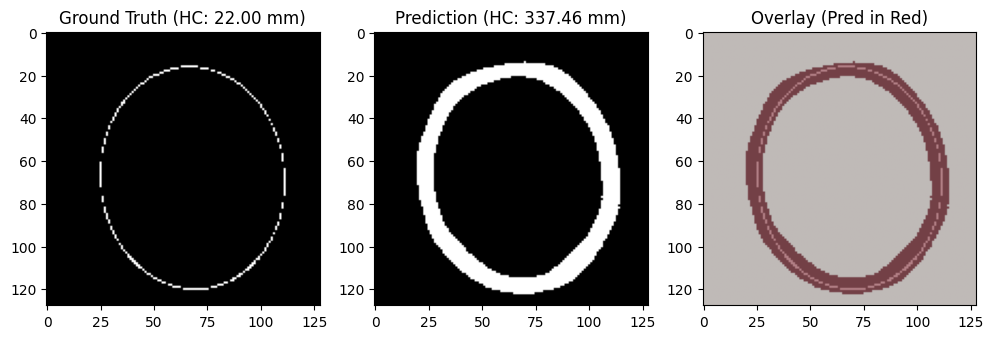

In [67]:
import cv2

def compute_circumference(mask):
    mask = mask.squeeze().astype(np.uint8)  # Ensure the mask is binary and 2D
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        return cv2.arcLength(contours[0], closed=True)  # Assumes the largest contour is the head
    return 0

# Compute HC in pixels (mm) for ground truth and predictions
hc_true_mm = [compute_circumference(y_test_binary[i]) for i in range(len(y_test_binary))]
hc_pred_mm = [compute_circumference(preds_test_binary[i]) for i in range(len(preds_test_binary))]

# Convert to NumPy arrays
hc_true_mm = np.array(hc_true_mm)
hc_pred_mm = np.array(hc_pred_mm)
# Mean Absolute Error (MAE) in mm
mae_hc = np.mean(np.abs(hc_pred_mm - hc_true_mm))

# Mean Relative Error (MRE) in percentage
mre_hc = np.mean([abs(pred - true) / true * 100 if true > 0 else 0 for pred, true in zip(hc_pred_mm, hc_true_mm)])

print(f"MAE (HC in mm): {mae_hc:.2f} mm")
print(f"MRE (HC in mm): {mre_hc:.2f}%")
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title(f"Ground Truth (HC: {hc_true_mm[1]:.2f} mm)")
plt.imshow(y_test_binary[1], cmap='gray')
plt.subplot(1, 3, 2)
plt.title(f"Prediction (HC: {hc_pred_mm[1]:.2f} mm)")
plt.imshow(preds_test_binary[1], cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Overlay (Pred in Red)")
plt.imshow(y_test_binary[1], cmap='gray', alpha=0.5)
plt.imshow(preds_test_binary[1], cmap='Reds', alpha=0.5)
plt.show()